# Enhance bart with tf computation graph

Author: Guanxiong Luo<br />
Email: guanxiong.luo@med.uni-goettingen.de

## Overview
This tutorial is to present how to create regularization term with tensorflow and use it for image reconstruction in bart.

<img src="over.png" width="800"/>

## What we have
TensorFlow provides C API that can be used to build bindings for other languages. 

1. bart src/nn/tf_wrapper.c

    * create tensors, create tf session

    * import the exported graph

    * restore the session from the saved model

    * get operation nodes from the graph

    * execute operation with session.run()


2. TensorFlow C Libraries [2.4.0](https://storage.googleapis.com/tensorflow/libtensorflow/libtensorflow-gpu-linux-x86_64-2.4.0.tar.gz)

3. A python program to export graph and weights (if any)

## What you can do with tf graph

1. we can create the regularization term $R(x)$ with tf graph for image reconstruction (integrated in bart pics).

$$\underset{x}{\arg \min}\ \|Ax-y\|^2+\lambda R(x)$$

## What you can learn here

1. simple example $R(x)=\|x\|^2$ without trainable weights

2. $R(x)=\log p(x, net(\Theta,x))$ with trainable weights $\Theta$, $net$ is represented as a prior [1]

[1] Luo, G, Zhao, N, Jiang, W, Hui, ES, Cao, P. MRI reconstruction using deep Bayesian estimation. Magn Reson Med. 2020; 84: 2246– 2261. https://doi.org/10.1002/mrm.28274 <br />
[2] Proc. Intl. Soc. Mag. Reson. Med. 29 (2021) P.1756

## Part I: How to create tf graph for bart

In [30]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

if True:
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np

### Step 1: define input $x$

In [31]:
image_shape = [256, 256, 2]
batch_size = 1

# CAPI -> TF_GraphOperationByName(graph, "input_0")
# give name with input_0, ..., input_I 
x = tf.placeholder(tf.float32,
                   shape=[batch_size]+image_shape,
                   name='input_0')
v = tf.Variable(1.)
x = x * v

### Step 2: define output $R(x)=\|x\|^2$

In [32]:
l2 = tf.nn.l2_loss(x)#/np.product(image_shape)/batch_size        #R(x)=|x|^2
# CAPI -> TF_GraphOperationByName(graph, "output_0") -> nlop forward
# give name with output_0, ..., output_I
output = tf.identity(tf.stack([l2, tf.ones_like(l2)], axis=-1), name='output_0') 

### Step 3: define the gradient of $R(x)=\|x\|^2$

In [33]:
grad_ys = tf.placeholder(tf.float32,
                         shape=[2],
                         name='grad_ys_0')

# CAPI -> TF_GraphOperationByName(graph, "grad_0") -> nlop adj
grads = tf.squeeze(tf.gradients(output, x, grad_ys), name='grad_0') 

### Step 4: export graph and weights (if any)

In [34]:
from utils import export_model
# export_model(model_path, exported_path, name, as_text, use_gpu):

export_model(None, "./", "l2_toy", as_text=False, use_gpu=False)

Exported


In [35]:
!ls

__pycache__	 ksp_256_c.hdr				      tensorflow
bart		 l2_pics.cfl				      traj_256.cfl
bart_tf.ipynb	 l2_pics.hdr				      traj_256.hdr
checkpoint	 l2_pics_tf.cfl				      traj_256_c.cfl
clean		 l2_pics_tf.hdr				      traj_256_c.hdr
coilsen_esp.cfl  l2_toy.data-00000-of-00001		      utils.py
coilsen_esp.hdr  l2_toy.index				      w_pics_prior.cfl
grid_ksp.cfl	 l2_toy.meta				      w_pics_prior.hdr
grid_ksp.hdr	 l2_toy.pb				      weights.cfl
ksp_256.cfl	 libtensorflow-gpu-linux-x86_64-2.4.0.tar.gz  weights.hdr
ksp_256.hdr	 over.png				      zero_filled.cfl
ksp_256_c.cfl	 prior					      zero_filled.hdr


In [36]:
# release the gpu
import IPython
IPython.Application.instance().kernel.do_shutdown(True) 

{'status': 'ok', 'restart': True}

##  Part II: How to use the graph in bart

###  Step 1: set bart

In [17]:
%%bash

# Download tensorflow c libraries
wget https://storage.googleapis.com/tensorflow/libtensorflow/libtensorflow-gpu-linux-x86_64-2.4.0.tar.gz
mkdir tensorflow && tar -C tensorflow -xvzf libtensorflow-gpu-linux-x86_64-2.4.0.tar.gz

./
./include/
./include/tensorflow/
./include/tensorflow/c/
./include/tensorflow/c/c_api.h
./include/tensorflow/c/c_api_experimental.h
./include/tensorflow/c/c_api_macros.h
./include/tensorflow/c/tensor_interface.h
./include/tensorflow/c/tf_attrtype.h
./include/tensorflow/c/tf_datatype.h
./include/tensorflow/c/tf_file_statistics.h
./include/tensorflow/c/tf_status.h
./include/tensorflow/c/tf_tensor.h
./include/tensorflow/c/tf_tstring.h
./include/tensorflow/core/
./include/tensorflow/core/platform/
./include/tensorflow/core/platform/ctstring.h
./include/tensorflow/core/platform/ctstring_internal.h
./lib/
./lib/libtensorflow.so.2.4.0
./lib/libtensorflow_framework.so.2.4.0
./lib/libtensorflow_framework.so
./lib/libtensorflow_framework.so.2
./lib/libtensorflow.so
./lib/libtensorflow.so.2
./THIRD_PARTY_TF_C_LICENSES
./LICENSE
./include/tensorflow/c/eager/
./include/tensorflow/c/eager/c_api.h
./include/tensorflow/c/eager/c_api_experimental.h
./include/tensorflow/c/eager/dlpack.h


--2021-05-14 13:41:34--  https://storage.googleapis.com/tensorflow/libtensorflow/libtensorflow-gpu-linux-x86_64-2.4.0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.206.128, 64.233.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 329013868 (314M) [application/x-tar]
Saving to: ‘libtensorflow-gpu-linux-x86_64-2.4.0.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 33.8M 9s
    50K .......... .......... .......... .......... ..........  0% 40.0M 9s
   100K .......... .......... .......... .......... ..........  0% 33.7M 9s
   150K .......... .......... .......... .......... ..........  0% 36.8M 9s
   200K .......... .......... .......... .......... ..........  0% 38.7M 9s
   250K .......... .......... .......... .......... ..........  0% 42.3M 8s
   300K .......... .......... .......... .......... ..........

In [18]:
%%bash

# Estimate GPU Type
GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

echo "GPU Type:"
echo $GPU_NAME

if [ "Tesla K80" = "$GPU_NAME" ];
then
    echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."

    # Install CUDA-10.1 if not already installed
    apt-get install cuda-10-1 cuda-drivers &> /dev/null

    # Change default CUDA to version 10.1
    cd /usr/local
    rm cuda
    ln -s cuda-10.1 cuda
    cd /content

else
    echo "GPU Information:"
    nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
    nvcc --version
    echo "Current GPU supports default CUDA-11."
    echo "No further actions are necessary."
fi


# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Download BART version
BRANCH=master
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart

[ -d "bart" ] && echo "BART branch ${BRANCH} was downloaded successfully."

cd bart

# Switch to desired branch of the BART project
git checkout $BRANCH

# Define specifications 
COMPILE_SPECS=" PARALLEL=4
                CUDA=1
                CUDA_BASE=/usr/local/cuda
                CUDA_LIB=lib64
                TENSORFLOW=1
                TENSORFLOW_BASE=../tensorflow/"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

make &> /dev/null

GPU Type:
Failed to initialize NVML: Driver/library version mismatch
GPU Information:
Failed to initialize NVML: Driver/library version mismatch
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
Current GPU supports default CUDA-11.
No further actions are necessary.
BART branch master was downloaded successfully.
Your branch is up to date with 'origin/master'.


Cloning into 'bart'...
Already on 'master'


In [5]:
%env LIBRARY_PATH=$LIBRARY_PATH:/content/tensorflow/include 
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/content/tensorflow/lib
%env TF_CPP_MIN_LOG_LEVEL=3

env: LIBRARY_PATH=$LIBRARY_PATH:/content/tensorflow/include
env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/content/tensorflow/lib
env: TF_CPP_MIN_LOG_LEVEL=3


In [6]:
import os
import sys

if not('TOOLBOX_PATH' in os.environ):
    os.environ['TOOLBOX_PATH'] = "/content/bart"
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python/")

### Step 2: check help info

In [1]:
!bart pics -Rh

2021-05-14 15:49:00.932209: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gluo/anaconda2/envs/tf15/cuda/lib::/home/gluo/anaconda2/envs/tf15/lib/python3.7/site-packages/tensorflow_core
2021-05-14 15:49:00.932283: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Generalized regularization options (experimental)

-R <T>:A:B:C	<T> is regularization type (single letter),
		A is transform flags, B is joint threshold flags,
		and C is regularization value. Specify any number
		of regularization terms.

-R Q:C    	l2-norm in image domain
-R I:B:C  	l1-norm in image domain
-R W:A:B:C	l1-wavelet
-R N:A:B:C	Normalized Iterative Hard Thresholding (NIHT), image domain
		C is an integer percentage, i.e. from 0-100
-R H:A:B:C	NIHT, wavelet doma

proximal operation on $R(x)$

$$\hat{x}=\underset{x}{\arg \min} \|x-v\|^2 + \lambda R(x)$$

### Step 3: extract radial spokes and compute coil sensitivities

In [2]:
%%bash
# prepare coil sensitivities and radial spokes
# explain the dimensions
spokes=60
nx=256

bart extract 2 0 $spokes ksp_256 ksp_256_c
bart extract 2 0 $spokes traj_256 traj_256_c

2021-05-14 15:49:04.040903: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gluo/anaconda2/envs/tf15/cuda/lib::/home/gluo/anaconda2/envs/tf15/lib/python3.7/site-packages/tensorflow_core
2021-05-14 15:49:04.040970: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-05-14 15:49:04.153647: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gluo/anaconda2/envs/tf15/cuda/lib::/home/gluo/anaconda2/envs/tf15/lib/python3.7/site-packages/tensorflow_core
2021-05-14 15:49:04.153711: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
!head -n2 ksp_256_c.hdr

# Dimensions
1 256 60 8 1 1 1 1 1 1 1 1 1 1 1 1 


In [4]:
%%bash 

bart nufft -i traj_256_c ksp_256_c zero_filled
bart fft $(bart bitmask 0 1) zero_filled grid_ksp
bart ecalib -r20 -m1 -c0.0001 grid_ksp coilsen_esp

Est. image size: 256 256 1
Done.
Done.


2021-05-14 15:50:47.084829: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gluo/anaconda2/envs/tf15/cuda/lib::/home/gluo/anaconda2/envs/tf15/lib/python3.7/site-packages/tensorflow_core
2021-05-14 15:50:47.084899: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-05-14 15:50:48.584204: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gluo/anaconda2/envs/tf15/cuda/lib::/home/gluo/anaconda2/envs/tf15/lib/python3.7/site-packages/tensorflow_core
2021-05-14 15:50:48.584259: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

## Example 1: $R(x)=\|x\|^2$

In [5]:
%%bash

graph_path=$(pwd)/l2_toy
lambda=0.01

bart pics -i100 -R TF:{$graph_path}:$lambda -d5 -e -t traj_256_c ksp_256_c coilsen_esp l2_pics_tf

[  1 256  60   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 256  60   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
nufft kernel dims: [  1 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 15360 (vs. 277504) + 262144
ksp : [  1 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 17.102463  (max = 26.653530/p90 = 17.102463/median = 

2021-05-14 15:50:52.393873: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gluo/anaconda2/envs/tf15/cuda/lib::/home/gluo/anaconda2/envs/tf15/lib/python3.7/site-packages/tensorflow_core
2021-05-14 15:50:52.393948: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-05-14 15:50:53.538519: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-05-14 15:50:53.544723: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [6]:
%%bash

bart pics -l2 0.01 -e -d5 -t traj_256_c ksp_256_c coilsen_esp l2_pics

[  1 256  60   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 256  60   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
nufft kernel dims: [  1 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 15360 (vs. 277504) + 262144
ksp : [  1 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 256  60   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 17.102463  (max = 26.653530/p90 = 17.102463/median = 

2021-05-14 15:51:02.442996: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gluo/anaconda2/envs/tf15/cuda/lib::/home/gluo/anaconda2/envs/tf15/lib/python3.7/site-packages/tensorflow_core
2021-05-14 15:51:02.443066: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(-0.5, 255.5, 255.5, -0.5)

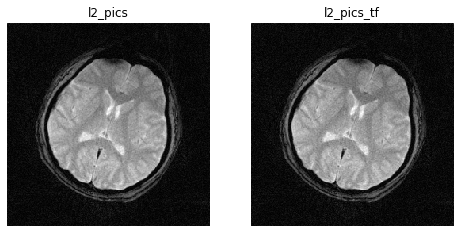

In [7]:
from utils import *
import matplotlib.pyplot as plt
fig, axis = plt.subplots(figsize=(8,4), ncols=2)
l2_pics = readcfl("l2_pics")
l2_pics_tf = readcfl("l2_pics_tf")

axis[0].imshow(abs(l2_pics), cmap='gray', interpolation='None')
axis[1].imshow(abs(l2_pics_tf), cmap='gray', interpolation='None')
axis[0].set_title("l2_pics")
axis[1].set_title("l2_pics_tf")
axis[0].axis('off')
axis[1].axis('off')

## Example 2: $R(x)=\log p(x, net(x))$ 

In [8]:
# generate weights for density compensation
writecfl("weights", gen_weights(60, 256))           

In [ ]:
!ls prior/

In [ ]:
%%bash

graph_path=./prior/pixel_cnn
lamba=8
bart pics -i30 -R TF:{$graph_path}:$lamba -d5 -e -I\
              -p weights   \
              -t traj_256_c \
              ksp_256_c coilsen_esp w_pics_prior

In [ ]:
import matplotlib.pyplot as plt
pics_prior = readcfl("w_pics_prior")
fig, axis = plt.subplots(figsize=(12,4), ncols=3)

axis[0].imshow(abs(l2_pics), cmap='gray', interpolation='None')
axis[0].set_title("l2_pics")
axis[1].imshow(abs(l2_pics_tf), cmap='gray', interpolation='None')
axis[1].set_title("l2_pics_tf")
axis[2].imshow(abs(pics_prior), cmap='gray', interpolation='None')
axis[2].set_title("prior_pics")
axis[0].axis('off')
axis[1].axis('off')
axis[2].axis('off')


In [ ]:
! bash clean